# Linear regression

## Apply a multiple linear regresssion on the given dataset.

### Variable list

* G3: dependent variable, which means final grade (numeric from 0 to 20)
* school: school (binary: GP or MS)
* sex: sex (binary: F or M)
* age: age (numeric from 15 to 22)
* address: home address type (binary: U or R)
* famsize: family size (binary: LE3 or GT3)
* Pstatus: parent's cohabitation status (binary: T or A)
* Medu: mother's education (ordinal: from 0 to 4)
* Fedu: father's education (ordinal: from 0 to 4)
* Mjob: mother's job (nominal: 5 categories)
* Fjob: father's job (nominal: 5 categories)
* reason: reason to choose this school (nominal: 3 categories)
* guardian: guardian (nominal: 3 categories)
* traveltime: home to school travel time (ordinal: from 1 to 4)
* studytime: weekly study time (ordinal: from 1 to 4)
* failures: number of pass class failures (ordinal: from 1 to 4)
* schoolsup: extra educational support (binary: yes or no)
* famsup: family educational support (binary: yes or no)
* paid: extra paid classes within the course subject (binary: yes or no)
* activities: extra-curricular activities (binary: yes or no)
* nursery: attended nursery school (binary: yes or no)
* higher: wants to take higher education (binary: yes or no)
* internet: internet access at home (binary: yes or no)
* romantic: with a romantic relationship (binary: yes or no)
* famrel: quality of family relationship (ordinal: from 1 to 5)
* freetime: free time after school (ordinal: from 1 to 5)
* goout: going out with friends (ordinal: from 1 to 5)
* Dalc: Workday alcohol consumption (ordinal: from 1 to 5)
* Walc: Weekend alcohol consumption (ordinal: from 1 to 5)
* health: current health status (ordinal: from 1 to 5)
* absences: number of school absences (numeric: from 0 to 93)
* course: course of the grade (binary: math or portuguese)

In [1]:
binaries = [
    "school", "sex", "address", "famsize", "Pstatus", "schoolsup", 
    "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic", 
    "course"
]
numerics = ["age", "absences"]
ordinal = [
    "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", "goout", 
    "Dalc", "Walc", "health"
]
nominal = ["Mjob", "Fjob", "reason", "guardian"]

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t, f, chi2, skew, kurtosis
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("students_grade.csv")
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,course
0,GP,F,18.0,U,NaN,A,4.0,4.0,at_home,teacher,...,no,4.0,3.0,4.0,1.0,1.0,3.0,6.0,6.0,math
1,GP,F,17.0,U,NaN,T,1.0,1.0,at_home,other,...,no,5.0,3.0,3.0,1.0,1.0,3.0,4.0,6.0,math
2,GP,F,15.0,U,NaN,T,1.0,1.0,at_home,other,...,no,4.0,3.0,2.0,2.0,3.0,3.0,10.0,10.0,math
3,GP,F,15.0,U,NaN,T,4.0,2.0,health,services,...,yes,3.0,2.0,NaN,1.0,1.0,5.0,2.0,15.0,math
4,GP,F,16.0,U,NaN,T,3.0,3.0,other,other,...,no,4.0,3.0,2.0,1.0,2.0,5.0,4.0,10.0,math


## Part 1: Pre-processing

1-(1). some input variables contain missing values. If the proportion of missing values in a variable exceeds 80%, the variable should be excluded from the dataset. Is there any variable to be excluded?

In [3]:
missing_ratio = df.isnull().sum() / len(df)

high_missing_vars = missing_ratio[missing_ratio > 0.8].index
print("Variables with more than 80% missing values:", high_missing_vars)

df_cleaned = df.drop(columns=high_missing_vars)


Variables with more than 80% missing values: Index(['famsize', 'activities'], dtype='object')


1-(2) After excluding some variables if necessary, some rows containing missing values should be deleted from the dataset. After removing any sample with missing values, how many samples remain in the dataset?

In [4]:

df_cleaned = df_cleaned.dropna()
remaining_samples = len(df_cleaned)
print("Remaining samples after removing rows with missing values:", remaining_samples)


Remaining samples after removing rows with missing values: 761


### For all subsequent questions, the data pre-processed above are used.

Transform binaries or nominal variables into dummy variables (0 and 1) for further analysis.

In [5]:
categorical_vars = df_cleaned.select_dtypes(include=['object']).columns
df_dummies = pd.get_dummies(df_cleaned, columns=categorical_vars, drop_first=True)


1-(3) Find the top 10 input variables that show the high linear correlation with the target based on the correlation coefficients.

In [6]:
correlation_matrix = df_dummies.corr()
correlation_with_target = correlation_matrix['G3'].drop('G3')
top_10_features = correlation_with_target.abs().sort_values(ascending=False).head(10)
print("Top 10 variables with the highest correlation with the target:")
print(top_10_features)


Top 10 variables with the highest correlation with the target:
failures             0.355073
higher_yes           0.260030
Medu                 0.210133
Fedu                 0.186575
course_portuguese    0.182414
studytime            0.142846
school_MS            0.136915
romantic_yes         0.128696
age                  0.124083
guardian_other       0.122843
Name: G3, dtype: float64


1-(4) Draw pairwise scatter plots - one scatter plot illustrates the pairwise relatinoship between one of input variables selected in 1-(3) and output target.

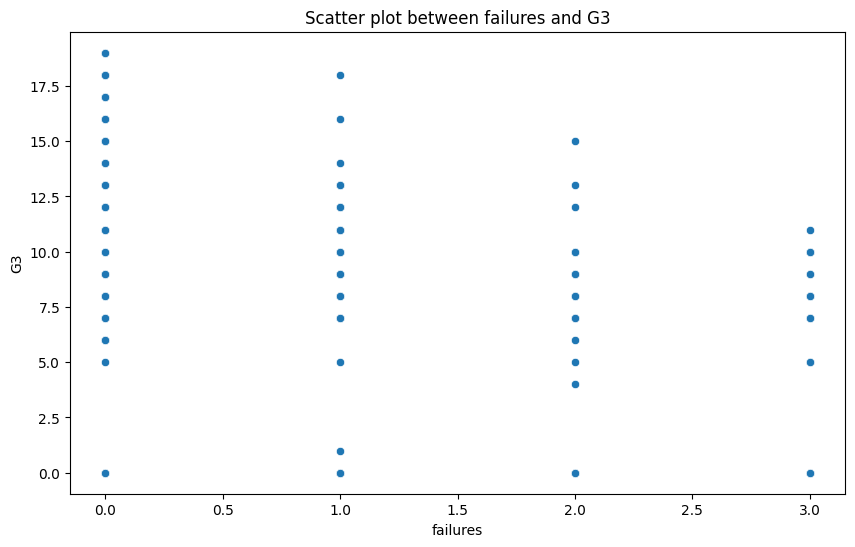

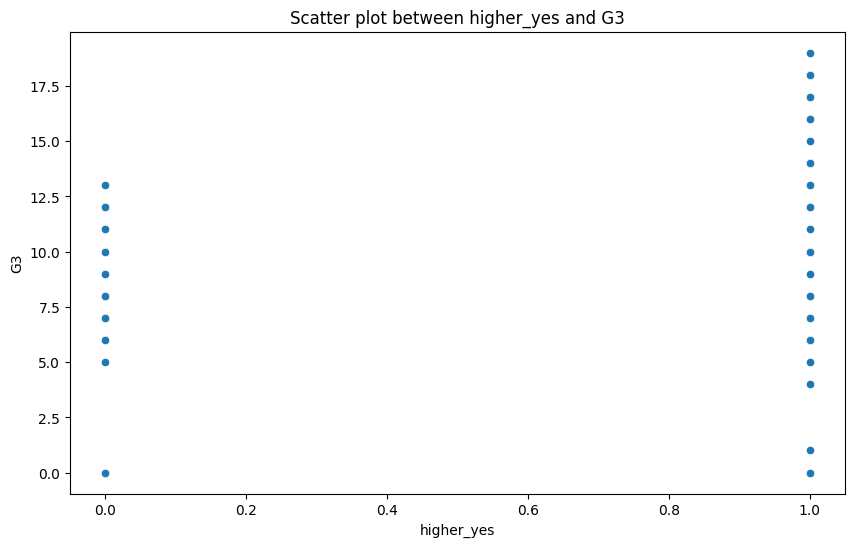

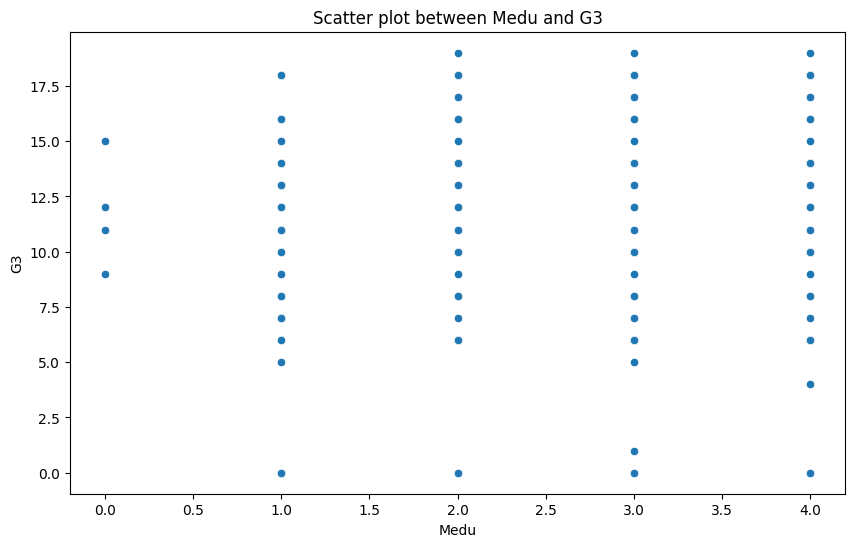

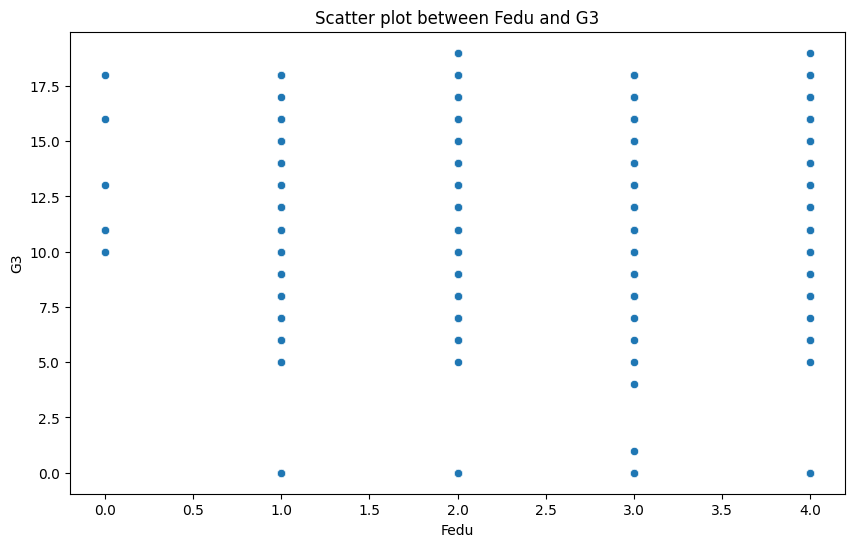

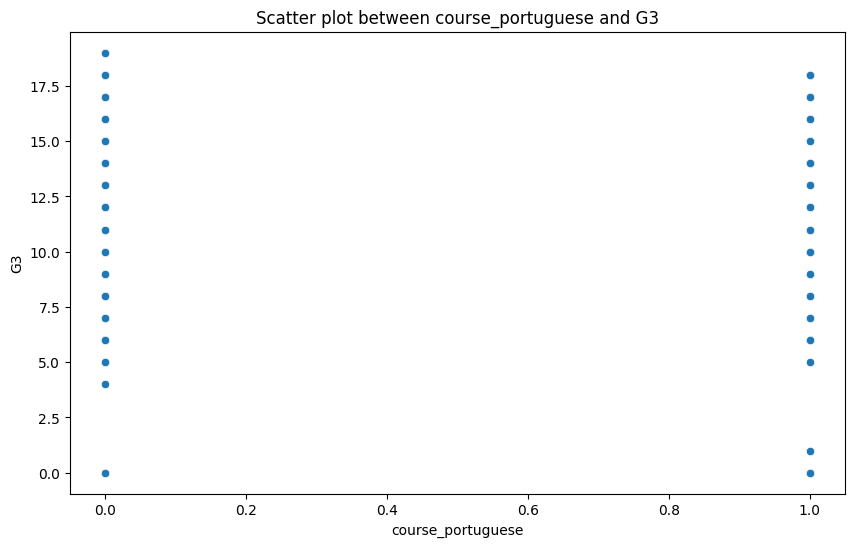

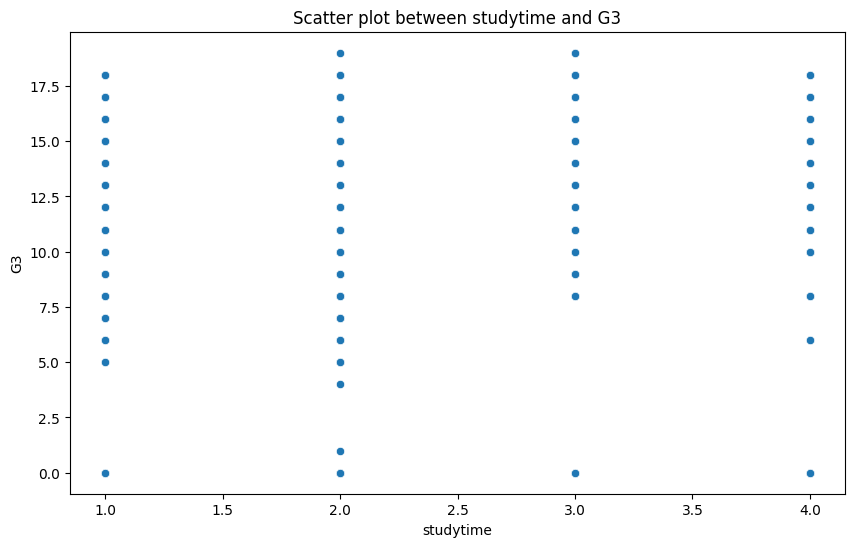

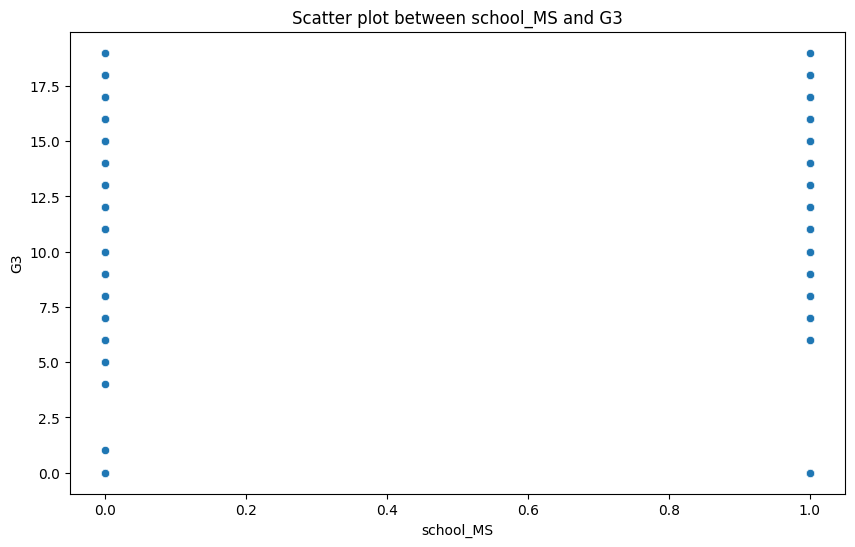

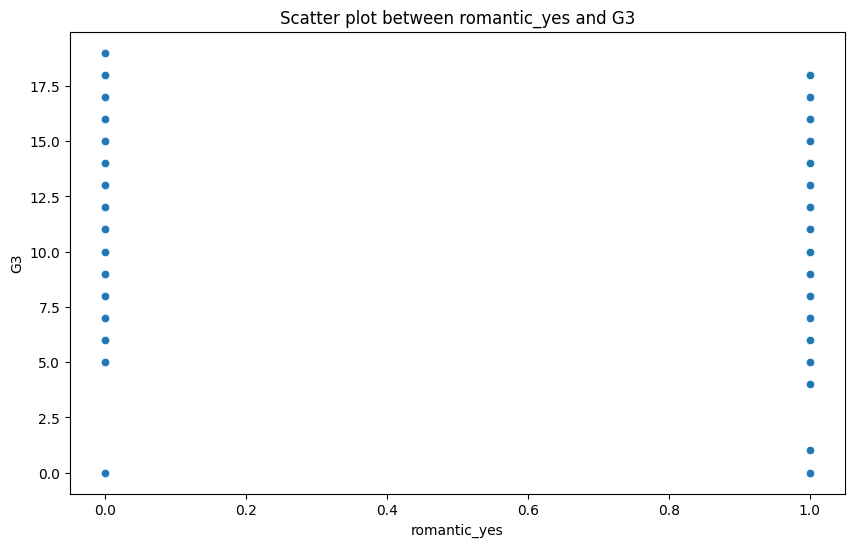

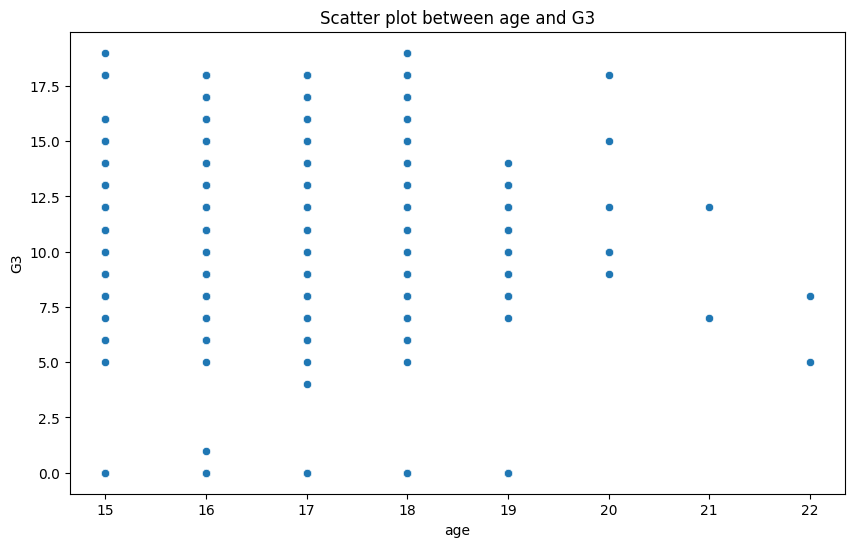

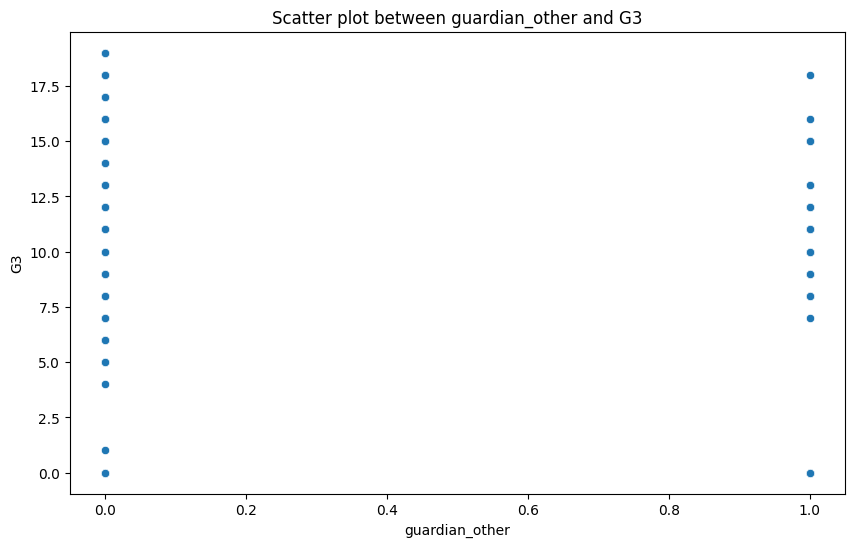

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in top_10_features.index:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_dummies, x=feature, y='G3')
    plt.title(f'Scatter plot between {feature} and G3')
    plt.xlabel(feature)
    plt.ylabel('G3')
    plt.show()


1-(5) Calculate variance inflation factor (VIF) for each explanatory variable and summarize the values using a table.

In [11]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [
        1 / (1 - LinearRegression().fit(np.delete(X.values, i, axis=1), X.values[:, i]).score(np.delete(X.values, i, axis=1), X.values[:, i]))
        for i in range(X.shape[1])
    ]
    return vif_data

X = df_dummies.drop(columns=['G3'])
vif_data = calculate_vif(X)
print("Variance Inflation Factor (VIF) for each explanatory variable:")
print(vif_data)


Variance Inflation Factor (VIF) for each explanatory variable:
              Feature       VIF
0                 age  1.387076
1                Medu  2.793371
2                Fedu  2.197712
3          traveltime  1.293233
4           studytime  1.250828
5            failures  1.322167
6              famrel  1.126390
7            freetime  1.248377
8               goout  1.404630
9                Dalc  1.848683
10               Walc  2.122403
11             health  1.123228
12           absences  1.218033
13          school_MS  1.581167
14              sex_M  1.344878
15          address_U  1.317152
16          Pstatus_T  1.130738
17        Mjob_health  1.796422
18         Mjob_other  2.311439
19      Mjob_services  2.372286
20       Mjob_teacher  2.540699
21        Fjob_health  1.775127
22         Fjob_other  4.833873
23      Fjob_services  4.366471
24       Fjob_teacher  2.213269
25        reason_home  1.324519
26       reason_other  1.225907
27  reason_reputation  1.350734
28    gua

1-(6) According to the results of question 1-(5), describe your opinion on how to select which variables should be excluded from training a linear regression model. Only in this assignment, if the VIF is 4 or greater, the multicollinearity is considerede to be severe.

## Part 2: Modeling

2-(1) Train a linear regression model (M1) using all variables and fill the following table.

In [39]:

X = df_dummies.drop(columns=['G3'])
y = df_dummies['G3']
X_m1 = sm.add_constant(X)

model_m1 = sm.OLS(y.astype(float), X_m1.astype(float)).fit()

coefficients_m1 = model_m1.summary2().tables[1]
print(coefficients_m1)


                      Coef.  Std.Err.         t         P>|t|    [0.025  \
const              6.769836  2.301893  2.940986  3.376330e-03  2.250632   
age                0.088557  0.114256  0.775070  4.385519e-01 -0.135758   
Medu               0.178568  0.182317  0.979436  3.276925e-01 -0.179367   
Fedu               0.092802  0.161971  0.572956  5.668530e-01 -0.225188   
traveltime         0.015279  0.181455  0.084200  9.329205e-01 -0.340964   
studytime          0.311289  0.159103  1.956524  5.078857e-02 -0.001071   
failures          -1.283212  0.206145 -6.224792  8.174547e-10 -1.687928   
famrel             0.352765  0.134150  2.629627  8.729850e-03  0.089394   
freetime           0.182381  0.133326  1.367937  1.717575e-01 -0.079371   
goout             -0.315549  0.124801 -2.528423  1.166964e-02 -0.560566   
Dalc              -0.053526  0.181786 -0.294448  7.685003e-01 -0.410418   
Walc               0.042870  0.136323  0.314474  7.532516e-01 -0.224766   
health            -0.2637

2-(2) Train a linear regression model (M2) using the selected variable in question 1-(3) and fill the following table.

In [41]:
top_10_features = correlation_with_target.abs().sort_values(ascending=False).head(10).index.tolist()
X_m2 = sm.add_constant(df_dummies[top_10_features])
y_m2 = df_dummies['G3']

model_m2 = sm.OLS(y_m2.astype(float), X_m2.astype(float)).fit()

coefficients_m2 = model_m2.summary2().tables[1]
print(coefficients_m2)


                      Coef.  Std.Err.         t         P>|t|    [0.025  \
const              5.729305  1.970948  2.906877  3.758213e-03  1.860073   
failures          -1.401858  0.203443 -6.890659  1.177565e-11 -1.801244   
higher_yes         2.133628  0.468250  4.556596  6.067605e-06  1.214390   
Medu               0.347165  0.150274  2.310217  2.114674e-02  0.052158   
Fedu               0.134870  0.149402  0.902730  3.669589e-01 -0.158427   
course_portuguese  1.818379  0.266649  6.819373  1.882659e-11  1.294912   
studytime          0.314788  0.151064  2.083808  3.751563e-02  0.018230   
school_MS         -1.131269  0.301710 -3.749524  1.908068e-04 -1.723566   
romantic_yes      -0.747690  0.260299 -2.872421  4.188385e-03 -1.258692   
age                0.097875  0.109772  0.891623  3.728809e-01 -0.117622   
guardian_other    -0.444583  0.514358 -0.864346  3.876741e-01 -1.454335   

                     0.975]  
const              9.598537  
failures          -1.002472  
higher_ye

2-(3) Train a linear regression model (M3) using the selected variables in question 1-(6) and fill the following table.

In [45]:
selected_features = vif_data[vif_data['VIF'] < 4]['Feature']
X_m3 = sm.add_constant(df_dummies[selected_features])
y_m3 = df_dummies['G3']
model_m3 = sm.OLS(y_m3.astype(float), X_m3.astype(float)).fit()
print(model_m3.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8.141
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           3.59e-34
Time:                        19:08:46   Log-Likelihood:                -1974.3
No. Observations:                 761   AIC:                             4023.
Df Residuals:                     724   BIC:                             4194.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.5767      2.23

## Part 3: Assessment

3-(1) Apply the F-test on M1, M2, and M3 and explain the results. In addition fill the following table.

In [51]:
feature_accuracies = {}

for feature in X_train.columns:
    model = LogisticRegression()
    model.fit(X_train[[feature]], y_train)
    y_pred = model.predict(X_test[[feature]])
    accuracy = accuracy_score(y_test, y_pred)
    feature_accuracies[feature] = accuracy

accuracy_df = pd.DataFrame.from_dict(feature_accuracies, orient='index', columns=['Accuracy']).reset_index()
accuracy_df = accuracy_df.rename(columns={'index': 'Feature'})
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)
print(accuracy_df)


  Feature  Accuracy
0   ap_hi  0.720359
1   ap_lo  0.677844


3-(2) Calculate R-square and adjusted R-square for M1, M2, and M3. Then, compare the models.

/opt/anaconda3/envs/dmclass/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


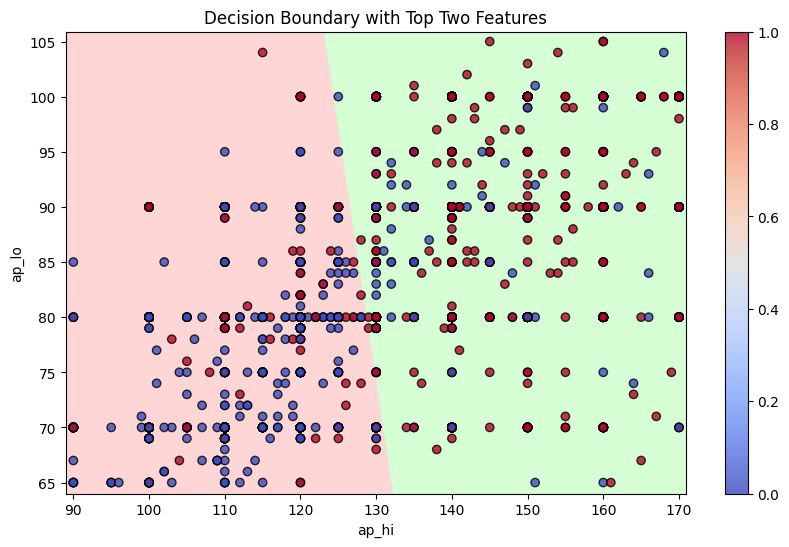

In [52]:
top_two_features = accuracy_df['Feature'].iloc[:2].tolist()
X_train_top2 = X_train[top_two_features]
X_test_top2 = X_test[top_two_features]

model_top2 = LogisticRegression()
model_top2.fit(X_train_top2, y_train)

x_min, x_max = X_train_top2.iloc[:, 0].min() - 1, X_train_top2.iloc[:, 0].max() + 1
y_min, y_max = X_train_top2.iloc[:, 1].min() - 1, X_train_top2.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = model_top2.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, levels=[0, 0.5, 1], colors=['#ffcccc', '#ccffcc'])
plt.scatter(X_train_top2.iloc[:, 0], X_train_top2.iloc[:, 1], c=y_train, edgecolors='k', marker='o', cmap=plt.cm.coolwarm, alpha=0.8)
plt.title('Decision Boundary with Top Two Features')
plt.xlabel(top_two_features[0])
plt.ylabel(top_two_features[1])
plt.colorbar()
plt.show()


3-(4) Obtain the residual plots of M1, M2, and M3 (x: predicted values, y: residuals) and assess the assumptions related to errors based on the plots.

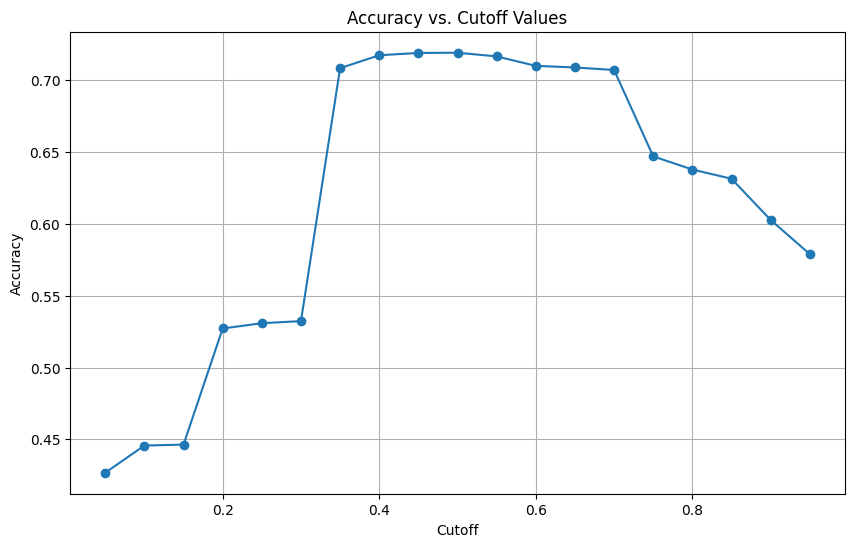

In [53]:
model_all = LogisticRegression()
model_all.fit(X_train, y_train)

def calculate_accuracy_with_cutoffs(model, X_test, y_test, cutoffs):
    accuracies = []
    for cutoff in cutoffs:
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= cutoff).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return accuracies

cutoffs = np.arange(0.05, 1.0, 0.05)

accuracies = calculate_accuracy_with_cutoffs(model_all, X_test, y_test, cutoffs)

plt.figure(figsize=(10, 6))
plt.plot(cutoffs, accuracies, marker='o')
plt.title('Accuracy vs. Cutoff Values')
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


3-(5) Do residuals of M1, M2, and M3 follow the normal distribution based on the Jarque-Bera test? (significance level is 0.05). If residuals do not follow the normal distribution, what might be the cause?

In [20]:
from statsmodels.stats.stattools import jarque_bera

jb_m1 = jarque_bera(residuals_m1)
jb_m2 = jarque_bera(residuals_m2)
jb_m3 = jarque_bera(residuals_m3)

print("Jarque-Bera test results:")
print(f"M1 - JB Statistic: {jb_m1[0]}, p-value: {jb_m1[1]}")
print(f"M2 - JB Statistic: {jb_m2[0]}, p-value: {jb_m2[1]}")
print(f"M3 - JB Statistic: {jb_m3[0]}, p-value: {jb_m3[1]}")

alpha = 0.05
print("\nNormality check based on Jarque-Bera test:")
print(f"M1 - Residuals {'do not follow' if jb_m1[1] < alpha else 'follow'} the normal distribution.")
print(f"M2 - Residuals {'do not follow' if jb_m2[1] < alpha else 'follow'} the normal distribution.")
print(f"M3 - Residuals {'do not follow' if jb_m3[1] < alpha else 'follow'} the normal distribution.")


Jarque-Bera test results:
M1 - JB Statistic: 325.90601181629535, p-value: 1.6998426610060648e-71
M2 - JB Statistic: 237.93177897283277, p-value: 2.1566052660098943e-52
M3 - JB Statistic: 330.294264666054, p-value: 1.8945746657392215e-72

Normality check based on Jarque-Bera test:
M1 - Residuals do not follow the normal distribution.
M2 - Residuals do not follow the normal distribution.
M3 - Residuals do not follow the normal distribution.


# Logistic regression

Using Cardiovascular disease dataset, build a classifier through logistic regression.

The included variables in this dataset as follows.

* cardio: Dependent variable, indicating the presence or absence of cardiovascular disease (binary: yes or no)
* age: age of the individuals in years
* gender: gender (binary: F or M)
* height: height in centimeters
* weight: weight in kilograms
* ap_hi: systolic blood pressure
* ap_lo: diastolic blood pressure
* cholesterol: cholesterol level (ordinal: from 1 to 3)
* gluc: glucose level (ordinal: from 1 to 3)
* smoke: whether a person smokes (binary: yes or no)
* alco: whether a person consumes alcohol (binary: yes or no)
* active: whether a person engages in regular physical activity (binary: yes or no)
  

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [28]:
df = pd.read_csv("cardio_original.csv")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,61,F,155,69.0,130,80,above normal,above normal,no,no,yes,no
1,40,F,163,71.0,110,70,normal,normal,no,no,yes,yes
2,60,F,165,70.0,120,80,normal,normal,no,no,yes,no
3,39,M,165,85.0,120,80,normal,normal,yes,yes,yes,no
4,64,F,155,62.0,120,80,normal,normal,no,no,yes,no


In [29]:
df["gender"] = df["gender"].map({"M": 1, "F": 0})
df["cholesterol"] = df["cholesterol"].map(
    {"normal": 1, "above normal": 2, "well above normal": 3}
)
df["gluc"] = df["gluc"].map(
    {"normal": 1, "above normal": 2, "well above normal": 3}
)
df["smoke"] = df["smoke"].map({"yes": 1, "no": 0})
df["alco"] = df["alco"].map({"yes": 1, "no": 0})
df["active"] = df["active"].map({"yes": 1, "no": 0})
df["cardio"] = df["cardio"].map({"yes": 1, "no": 0})

In [30]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,61,0,155,69.0,130,80,2,2,0,0,1,0
1,40,0,163,71.0,110,70,1,1,0,0,1,1
2,60,0,165,70.0,120,80,1,1,0,0,1,0
3,39,1,165,85.0,120,80,1,1,1,1,1,0
4,64,0,155,62.0,120,80,1,1,0,0,1,0


(1) pre-process data. Some data samples have outliers for some variables, and they need to be properly addressed for accurate analysis. Implement box-plot-based outlier removal.

After removing outliers, split the whole dataset into training/test sets (8:2). Please maintain the same ratio of classes in both the training and test set.

In [31]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_columns:
    df = remove_outliers(df, col)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cardio'], random_state=42)

(2) Train logistic regression model using one of the explanatory variables using x_train and then calculate accuracy of the models using x_valid. Which variable is the most important according to the accuracy?

In [32]:
def train_logistic_regression(train_df, test_df, feature):
    X_train = train_df[[feature]]
    y_train = train_df['cardio']
    X_test = test_df[[feature]]
    y_test = test_df['cardio']
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

features = train_df.columns.drop('cardio')
feature_accuracies = {feature: train_logistic_regression(train_df, test_df, feature) for feature in features}

accuracy_df = pd.DataFrame.from_dict(feature_accuracies, orient='index', columns=['Accuracy']).reset_index()
accuracy_df = accuracy_df.rename(columns={'index': 'Feature'})
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)
print(accuracy_df)


        Feature  Accuracy
4         ap_hi  0.720359
5         ap_lo  0.677844
0           age  0.615113
3        weight  0.592010
1        gender  0.575004
2        height  0.575004
6   cholesterol  0.575004
7          gluc  0.575004
8         smoke  0.575004
9          alco  0.575004
10       active  0.575004


(3) Using the top two variables with the highest accuracy obtained for queestion (1), train a logistic regression model on x_train. Draw the decision boundary showing equal probability values for classes 0 and 1 (x: 1st rank variable, y: 2nd rank variable) with scatterplots of the samples used for the training (assign different colors depending on the predicted class for the scatterplot)

/opt/anaconda3/envs/dmclass/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


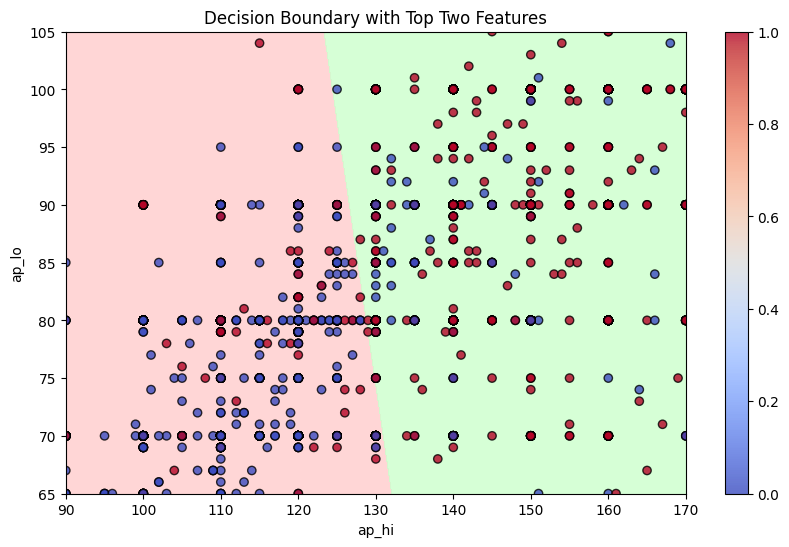

In [33]:
top_features = accuracy_df['Feature'].iloc[:2].tolist()
X_train = train_df[top_features]
y_train = train_df['cardio']
X_test = test_df[top_features]
y_test = test_df['cardio']

model = LogisticRegression()
model.fit(X_train, y_train)

xx, yy = np.meshgrid(np.linspace(X_train[top_features[0]].min(), X_train[top_features[0]].max(), 100),
                     np.linspace(X_train[top_features[1]].min(), X_train[top_features[1]].max(), 100))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, levels=[0, 0.5, 1], colors=['#ffcccc', '#ccffcc'])
plt.scatter(X_train[top_features[0]], X_train[top_features[1]], c=y_train, edgecolors='k', marker='o', cmap=plt.cm.coolwarm, alpha=0.8)
plt.title('Decision Boundary with Top Two Features')
plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.colorbar()
plt.show()


(4) Using cardiovascular disease dataset, calculate accuracy with varying cutoff for the final decision. Candidates of cutoff is [0.05, 0.1, ..., 0.95]. Draw a line plot (x: cutoff, y: accuracy). For this problem, the model is trained using x_train and accuracy is calculated using x_valid.

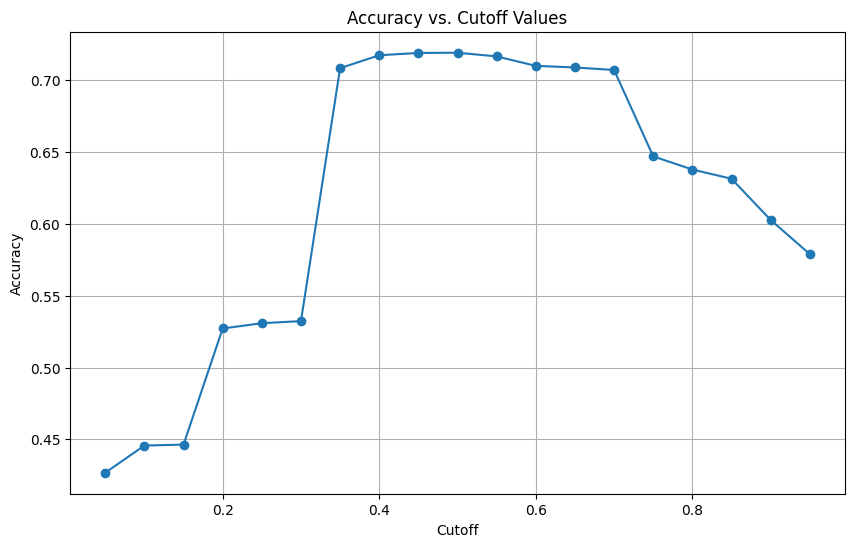

In [34]:
def calculate_accuracy_with_cutoffs(model, X_test, y_test, cutoffs):
    accuracies = []
    for cutoff in cutoffs:
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= cutoff).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return accuracies

cutoffs = np.arange(0.05, 1.0, 0.05)

accuracies = calculate_accuracy_with_cutoffs(model, X_test, y_test, cutoffs)

plt.figure(figsize=(10, 6))
plt.plot(cutoffs, accuracies, marker='o')
plt.title('Accuracy vs. Cutoff Values')
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
